In [1]:
# header / imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sc3nb as scn

In [2]:
from sc3nb import Buffer

example_file = "../media/blip.wav" 

In [3]:
sc = scn.startup()

<IPython.core.display.Javascript object>

Starting sclang process... 

Done.
Registering OSC /return callback in sclang... Done.
Loading default sc3nb SynthDefs... Done.
Booting SuperCollider Server... 

Done.


# Buffer

Buffer is the Python class in sc3nb to interface with Buffers on the SuperCollider server.

In [4]:
# uncomment following line to see help for the Buffer class:
# help(scn.Buffer)

## Create Buffer from a numpy.Array

In [5]:
d0 = np.random.rand(30000, 1)

In [6]:
buf0 = Buffer().load_data(d0)
buf0

<Buffer(128) on ('127.0.0.1', 57110): 1 x 30000 @ 44100 Hz = 0.680s allocated using mode 'data'>

In this case a default buffer with default sample rate (44100) and default insert mode is created.

If you want to create a buffer with a specific sample rate or OSC insertion method, etc. look at ```load_data``` 

In [7]:
scn.Buffer.load_data?

Attention: insertion via OSC is particularly useful for small datasets (e.g. less than 1000 entries). For larger datasets the default 'file' mode is much faster.

In [8]:
d0 = np.random.rand(30000, 1)
buf1 = Buffer().load_data(d0, sr=5000, mode='osc')
buf1

<Buffer(129) on ('127.0.0.1', 57110): 1 x 30000 @ 5000 Hz = 6.000s allocated using mode 'data'>

## Create Buffer with data from PyA Asig
This only works if using pya package: skip if you dont use pya

In [9]:
try:
    from pya import Ugen
except ImportError:
    pass
else:
    a1 = Ugen().sine(440, dur=1.0, sr=2000, channels=2).fade_out(0.5) # 1.0s sine tone of 440 Hz
    a1.plot()
    print(a1)
    buf1 = Buffer().load_asig(a1)
    buf1

Again, default transport method is mode='file', i.e. using a temporary file and fill the buffer on sc
with this content. 
* use mode="osc" to select the direct transfer of data via OSC messages

## Create Buffer of .wav File

In [10]:
buf2 = Buffer().read(example_file)
buf2

<Buffer(130) on ('127.0.0.1', 57110): 2 x 43008 @ 44100 Hz = 0.975s allocated using mode 'file'>

The buffer method will automatically read the sample reate of the file and set it to Buffer.sr

You can specify further arguments to `read`

In [11]:
scn.Buffer.read?

In [12]:
buf = Buffer().read(example_file, starting_frame=18000, num_frames=20000, channels=[1])
buf

<Buffer(131) on ('127.0.0.1', 57110): 1 x 20000 @ 44100 Hz = 0.454s allocated using mode 'file'>

## Allocate an empty Buffer

In [13]:
buf3 = Buffer().alloc(2.5*44100, sr=44100)
buf3

<Buffer(132) on ('127.0.0.1', 57110): 1 x 110250 @ 44100 Hz = 2.500s allocated using mode 'alloc'>

## Reuse an existing SC buffer

`Buffer.use_existing(bufnum)` will force the Buffer to (re-)use a buffer that already exists on the server, identified via its bufnum on the scsynth. 

In [14]:
# create a Buffer in SuperCollider
%sc b = Buffer.read(s, Platform.resourceDir +/+ "sounds/a11wlk01.wav");

-> Buffer(0, nil, nil, nil, C:\Program Files\SuperCollider-3.11.0\sounds/a11wlk01.wav)


In [15]:
bufnum = %scg b.bufnum
bufnum

-> 0


0

In [16]:
buf4 = Buffer()
buf4

<Buffer(None) on ('127.0.0.1', 57110): None x None @ None Hz = 0.000s not loaded using mode 'none'>

In [17]:
buf4.use_existing(bufnum)
buf4 # bufnum has now changed to be bufnum

<Buffer(0) on ('127.0.0.1', 57110): 1 x 188893 @ 44100 Hz = 4.283s allocated using mode 'existing'>

In [18]:
buf4.play()

<Synth(20001) 'sc3nb_playbuf_0' s {}>

## Copy an existing SC buffer
``copy_existing`` allows to copy an already existing buffer into another buffer.

In [19]:
buf5 = Buffer().read(example_file)
buf6 = Buffer().copy_existing(buf5)

This method will automatically use an intern SuperCollider copy method, if both buffer objects use the same sc instance. Otherwise the buffer will be loaded via filesystem. For this to happen, both sc instance should use the same filesystem. 

In [20]:
server2 = scn.SCServer(options=scn.ServerOptions(udp_port=57778))
server2.boot(kill_others=False)

Booting SuperCollider Server... 

Done.


In [21]:
sc.server.dump_osc()

In [22]:
server2.dump_osc()

In [23]:
buf7 = Buffer(server=server2).copy_existing(buf6)

c:\users\dennis\dev\soni\sc3nb\.tox\docs\lib\site-packages\sc3nb\sc_objects\buffer.py:188: WavFileWarning: Chunk (non-data) not understood, skipping it.
  self._path


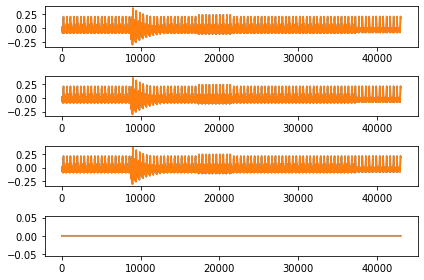

In [24]:
buf5sig = buf5.to_array()
buf6sig = buf6.to_array()
buf7sig = buf7.to_array()
fig, axs = plt.subplots(4,1)
axs[0].plot(buf5sig) # signal
axs[1].plot(buf6sig) # copied signal 
axs[2].plot(buf7sig) # copied signal on other server 
axs[3].plot(buf6sig-buf7sig); # difference (should be 0)
plt.tight_layout()

With this method, the complete buffer with all samples is copied. If you want to copy only a selection of samples, you can use `gen_copy()` (see below).

## Play Buffer

If you want to listen to the buffer, you can use ``play``.

In [25]:
d = np.sin(2 * np.pi * 440 * np.linspace(0, 3, 3 * 44100)**0.9)
buf8 = Buffer().load_data(d)

In [26]:
playbuf_synth = buf8.play()
playbuf_synth

<Synth(20002) 'sc3nb_playbuf_135' s {}>

As you can see `play()` returns an sc3nb Synth object for the Buffer.

This allows to control the playback via the synth class while the synth is running.

In [27]:
playbuf_synth.rate = 0.5

In [28]:
if not playbuf_synth.freed: # stop the playback if not done already
    playbuf_synth.free()
    playbuf_synth.wait()

In [29]:
playbuf_synth = buf8.play(rate=10, amp=0.15, pan=1)  # play at given rate and pan

In [30]:
playbuf_synth.wait(timeout=6)  # wait for synth to finish

You can get a description of the possible arguments with

In [31]:
scn.SynthDef.get_description(playbuf_synth.name)

{'out': SynthArgument(name='out', rate='control', default=0.0),
 'bufnum': SynthArgument(name='bufnum', rate='control', default=135.0),
 'rate': SynthArgument(name='rate', rate='control', default=1.0),
 'loop': SynthArgument(name='loop', rate='control', default=0.0),
 'pan': SynthArgument(name='pan', rate='control', default=0.0),
 'amp': SynthArgument(name='amp', rate='control', default=0.30000001192092896)}

and even can see the SynthDef here:

In [32]:
buf8._synth_def

SynthDef('sc3nb_playbuf_135', 
            { |out=0, bufnum=^bufnum, rate=^rate, loop=^loop, pan=^pan, amp=^amp |
                    var sig = PlayBuf.ar(^num_channels, bufnum,
                        rate*BufRateScale.kr(bufnum),
                        loop: loop,
                        doneAction: Done.freeSelf);
                    Out.ar(out, Pan2.ar(sig, pan, amp))
            })

You can get a description of the possible arguments with

In [33]:
scn.SynthDef.get_description(playbuf_synth.name)

{'out': SynthArgument(name='out', rate='control', default=0.0),
 'bufnum': SynthArgument(name='bufnum', rate='control', default=135.0),
 'rate': SynthArgument(name='rate', rate='control', default=1.0),
 'loop': SynthArgument(name='loop', rate='control', default=0.0),
 'pan': SynthArgument(name='pan', rate='control', default=0.0),
 'amp': SynthArgument(name='amp', rate='control', default=0.30000001192092896)}

As you can see the SC synth will free itself when done if you are not using the loop argument.

However with loop enabled you need to free the synth manually.

In [34]:
synth = buf8.play(rate=-4, loop=True)  # play looped 

In [35]:
synth.rate = 1 # change controls as needed

In [36]:
synth.free()

<Synth(20002) 'sc3nb_playbuf_135' f {'rate': 1, 'loop': 1, 'pan': 0, 'amp': 0.3}>

For more information regarding the Synth class, please refer to the [Node guide](node-examples.ipynb).

## Write Buffer content to file
Write the content of a buffer into a file. By default it is a .wav File with float as sample. You can change it via parameters "header" and "sample".

In [37]:
buf9 = Buffer().load_data(np.random.rand(10000)-0.5)

In [38]:
buf9.write("../media/output.wav")

<Buffer(136) on ('127.0.0.1', 57110): 1 x 10000 @ 44100 Hz = 0.227s allocated using mode 'data'>

In [39]:
# !ls -la ../media # uncomment if your shell offers ls

## Fetch Buffer content to array

In [40]:
# create a buffer
buf2 = Buffer().read(example_file)

In [41]:
data = buf2.to_array()

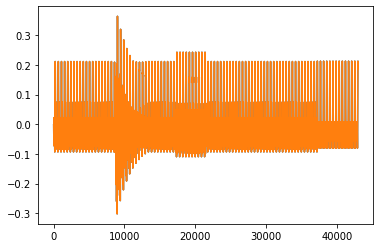

In [42]:
plt.plot(data);

In [43]:
buf2.play(rate=1)

<Synth(20003) 'sc3nb_playbuf_137' s {}>

## Fill Buffer with values

### Fill a Buffer with zeros:

In [44]:
scn.Buffer.zero?

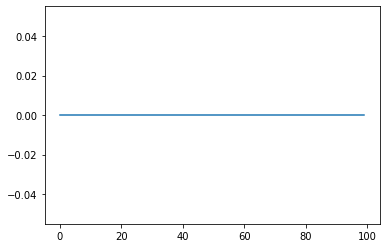

In [45]:
buf = Buffer().alloc(100)
buf.zero()
plt.plot(buf.to_array());

### Fill a Buffer range with values:

In [46]:
scn.Buffer.fill?

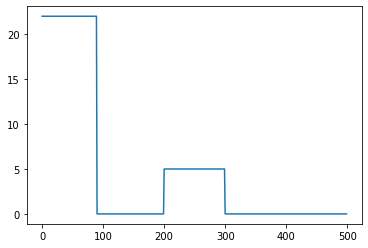

In [47]:
buf = Buffer().alloc(500).fill(0, 90, 22).fill(200, 100, 5)
plt.plot(buf.to_array());

Alternatively: fill buffer with single fill statement using multiple value triplets

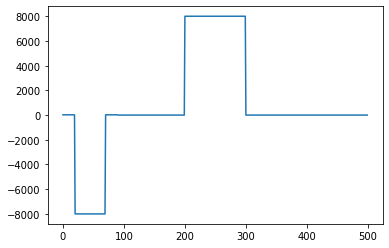

In [48]:
buf.fill([20, 50, -8000, 200, 100, 8000])
plt.plot(buf.to_array());

### Fill Buffer with sine wave harmonics of given amplitudes.

In [49]:
scn.Buffer.gen_sine1?

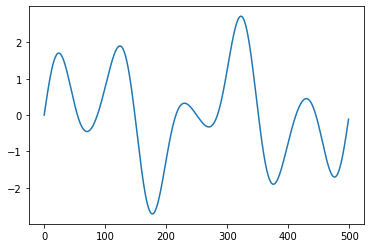

In [50]:
buf = Buffer().alloc(500).gen_sine1([1,-0.5,0,1.4,0,0,0.2])
plt.plot(buf.to_array());

### Fill Buffer with sine wave partials using specified frequencies and amplitudes.

In [51]:
scn.Buffer.gen_sine2?

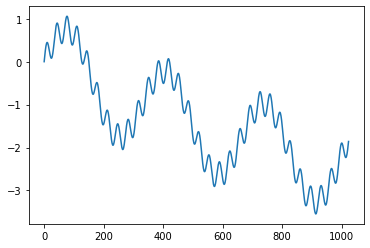

In [52]:
buf = Buffer().alloc(1024).gen_sine2([[3.1, 1], [0.2, -2.5], [30, 0.3]])
plt.plot(buf.to_array());

### Fill Buffer with sinus waves and given frequency, amplitude, phase

In [53]:
scn.Buffer.gen_sine3?

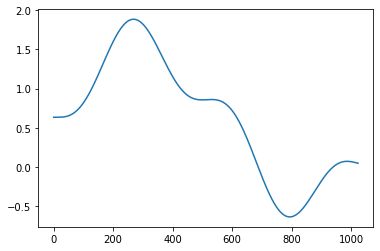

In [54]:
buf = Buffer().alloc(1024).gen_sine3(
    [[1, 0.9, 1], [2, 0.3, +np.pi/2], [3, 0.3, 3]])
plt.plot(buf.to_array());

### Fill Buffer with series of chebyshev polynomials:

In [55]:
scn.Buffer.gen_cheby?

$\textrm{cheby}(n) = \textrm{amplitude} \cdot \cos(n \cdot \arccos(x))$

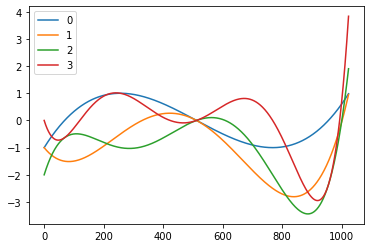

In [56]:
buf = Buffer().alloc(1024)
ch = [1]
for i in range(4):
    ch.insert(0, 0)
    buf.gen_cheby(ch)
    plt.plot(buf.to_array(), label=str(i));
plt.legend();

`gen_sine1` to `gen_sine3` and `gen_cheby` have the optional parameters:
* **normalize**: Normalize peak amplitude of wave to 1.0.
* **wavetable**: If set, then the buffer is written in wavetable format so that it can be read by interpolating oscillators.
* **clear**: if set then the buffer is cleared before new partials are written into it. Otherwise the new partials are summed with the existing contents of the buffer.

### Copy data of another Buffer:

In [57]:
scn.Buffer.gen_copy?

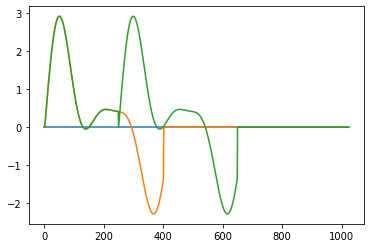

In [58]:
buf1 = Buffer().alloc(1024).fill(1024, 0, 0)
plt.plot(buf1.to_array());
buf2 = Buffer().alloc(1024).gen_sine1([1,0.5,0,1.4,0,0.5,0.2])

# copy samples 0..0+400 of buf2 into buf1 at position 2++ 
buf1.gen_copy(buf2, 0, 2, 400)  
plt.plot(buf1.to_array());

# copy samples 250..end(=<0) of buf2 into buf1 at position 250++ 
buf1.gen_copy(buf2, 0, 250, 400)
plt.plot(buf1.to_array());

Here we copy 100 samples of `buf2` at starting pos 1 to buf3 at position 2. Use a negative amount of samples to copy all available samples

## Get information about the Buffer
Information about the buffer object:

In [59]:
buf3

<Buffer(132) on ('127.0.0.1', 57110): 1 x 110250 @ 44100 Hz = 2.500s allocated using mode 'alloc'>

Information about the buffer in SC

In [60]:
buf3.query?

In [61]:
buf3.query()

BufferInfo(bufnum=132, num_frames=110250, num_channels=1, sample_rate=44100.0)

## Free Buffers

start with a buffer

In [62]:
buf = Buffer().read(example_file)
buf

<Buffer(146) on ('127.0.0.1', 57110): 2 x 43008 @ 44100 Hz = 0.975s allocated using mode 'file'>

In [63]:
buf.query()  # works as intended

BufferInfo(bufnum=146, num_frames=43008, num_channels=2, sample_rate=44100.0)

In [64]:
buf.free()

In [65]:
buf  # listed as not loaded, python Buffer instance still exists

<Buffer(146) on ('127.0.0.1', 57110): 2 x 43008 @ 44100 Hz = 0.975s not loaded using mode 'none'>

In [66]:
try:
    buf.query()  # raises an error after buf.free
except RuntimeError:
    pass
else:
    print("Buffer query on freed buffer should raise RuntimeError")

In [67]:
sc.exit()

Quitting SCServer... Done.
Exiting sclang... 

Done.
